## 1D Gaussian Process Regression on Synthetic Sine Data

This notebook is an educational experiment comparing two approaches to Gaussian Process (GP) regression:
- Numerical (Metropolis sampling) vs. Analytical posterior
- Visualization of mean predictions and uncertainty bands
- Iterative active learning: new data points are added where the model’s uncertainty is largest

The goal is to show how different inference methods approximate the true sine function and how uncertainty decreases as more data is added.

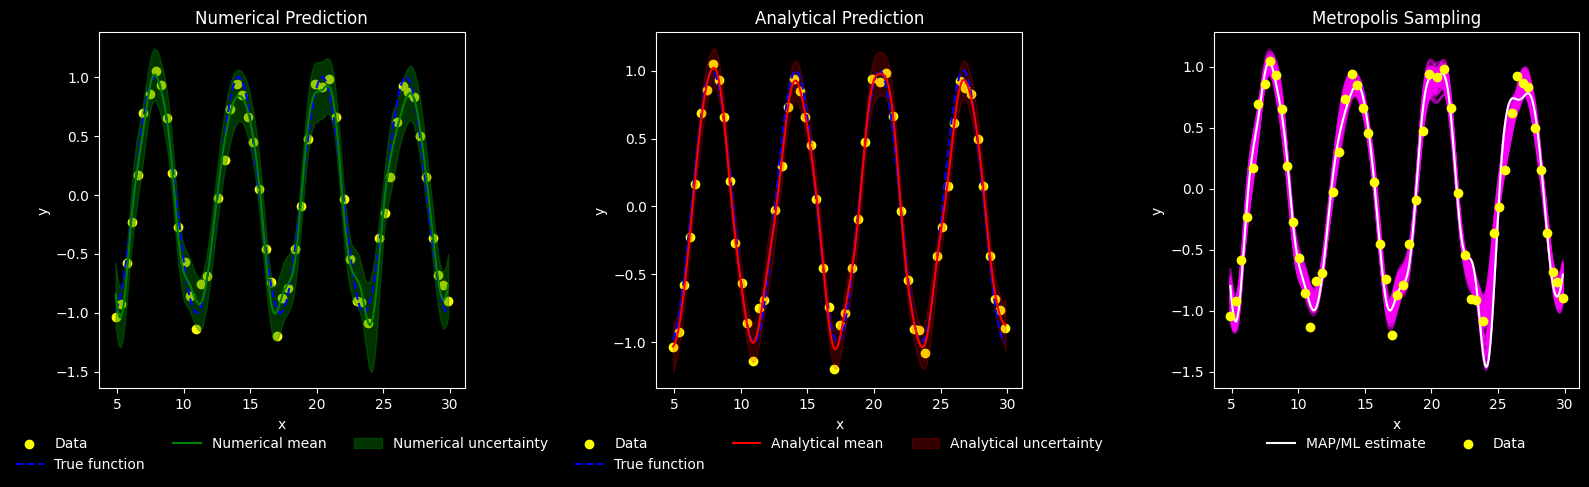

Plot for 51 iterations

In [1]:
import numpy as np
from math import e
from matplotlib import pyplot as plt

plt.style.use('dark_background')
np.random.seed(42)

In [2]:
'''generate data, define variables'''
gen_data = 2.0
x_act = np.random.uniform(0, 10 * np.pi, 5) # generated x values
sigma_noise = .1
y_act = np.sin(x_act) + np.random.normal(0, sigma_noise, size=x_act.shape) # generated y values
sigma_d = .1
sigma_k = .9
sigma_theta = .5
alpha = 0.0001
 # rearranged y values

iterations finished, loading plot...


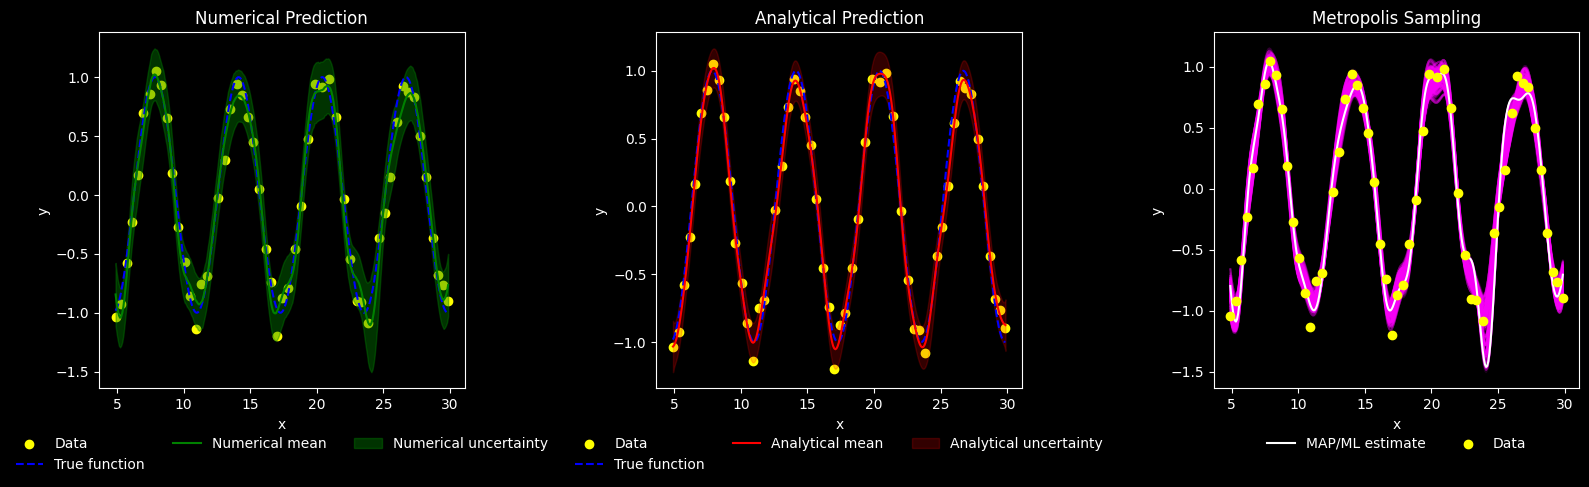

In [3]:
iterations = 51 # NOTE: adjust this value to change how many iterations run
for num in range(iterations):
    pre = []
    for i in range(x_act.size):
        pre.append([x_act[i], y_act[i]])
    data = np.array(pre)
    y_act = np.array([y_act])
    found_sigma = np.sqrt(1 / (np.sum(x_act**2) + 1))
    si = x_act.size
    '''define the RBF kernel function'''
    def rbf_kernel(x_set_1, x_set_2, sigma_k):
        if np.ndim(x_set_2) == 1:
            x_set_2 = x_set_2.reshape(-1, 1)
        if np.ndim(x_set_1) == 1:
            x_set_1 = x_set_1.reshape(-1, 1)
        x_set_1 = np.array(x_set_1)
        x_set_2 = np.array(x_set_2)
        sq_dist = (x_set_1 - x_set_2.T)**2
        k_mat = np.exp(-sq_dist / (2 * sigma_k**2))
        return k_mat


    '''finding x_k'''
    x_pre = []
    denom = 2 * sigma_k * sigma_k
    for counta in range(data.shape[0]):
        for countb in range(data.shape[0]):
            nume = (x_act[counta] - x_act[countb])**2
            add = e**(-nume/denom)
            x_pre.append(add)
    x_k = np.array(x_pre).reshape((si, si))


    '''eigen decompositio, finding phi_x'''
    eigenvalues, eigenvectors = np.linalg.eigh(x_k)
    threshold = 1e-10
    mask = eigenvalues > threshold
    eigenvalues = eigenvalues[mask]
    eigenvectors = eigenvectors[:, mask]
    phi_x = eigenvectors @ np.diag(np.sqrt(eigenvalues))


    '''find theta'''
    theta_ml = np.full(phi_x.shape[1], 1.)
    theta_ml = np.array([theta_ml])
    theta_ml = theta_ml.T
    '''gradient discent'''
    for i in range(10000):
        y_pred = np.dot(phi_x, theta_ml) # (5, 1)

        gradient = 2*(y_pred-y_act.T)
        gradient = phi_x.T @ gradient
        theta_ml -= alpha * gradient


    '''test'''
    x_test = np.linspace(x_act.min(), x_act.max(), 300)

    x_pre2 = []
    denom2 = 2 * sigma_k * sigma_k
    for count1 in range(x_test.shape[0]):
        for count2 in range(data.shape[0]):
            nume2 = (x_test[count1] - x_act[count2])**2
            add2 = e**(-nume2/denom2)
            x_pre2.append(add2)
    x_k_test = np.array(x_pre2).reshape((x_test.size, si))
    phi_x_test = x_k_test @ eigenvectors @ np.diag(1 / np.sqrt(eigenvalues))
    y_pred2 = np.dot(phi_x_test, theta_ml)


    '''metropolis'''
    def prob_a(y_act, x_act, a_i, sigma_a, sigma_d):
        return e**(-np.sum(((y_act - x_act @ a_i)**2) / (2*sigma_d**2))) * e**(-np.sum(a_i**2)/sigma_a**2)
    num_theta_samples = 500
    num_samples = 1
    step_size = np.eye(theta_ml.shape[0]) * 5e-4
    sigma_a = sigma_theta
    samples = []
    prev_theta = theta_ml.reshape(-1)
    for i in range(num_theta_samples):
        next_theta = np.random.multivariate_normal(prev_theta, step_size)
        r = prob_a(y_act, phi_x, next_theta, sigma_a, sigma_d) / prob_a(y_act, phi_x, prev_theta, sigma_a, sigma_d)
        if (r >= 1):
            samples.append(next_theta)
            prev_theta = next_theta
        elif(np.random.rand() <= r):
            samples.append(next_theta)
            prev_theta = next_theta
        else:
            samples.append(prev_theta)
    samples = np.array(samples)
    matrix = samples @ phi_x_test.T


    '''bayesian marginalization for numerical method'''
    posterior_mean_y = np.zeros(len(phi_x_test))
    posterior_var_y = np.zeros(len(phi_x_test))
    num_samples_predictive_per_theta = 5
    predictive_mean = phi_x_test @ samples.T # (300, 500)
    predictive_var = sigma_d**2
    individual_pred_dist = np.random.normal(0, np.sqrt(predictive_var), 
                                            (predictive_mean.shape[0], num_theta_samples, 5)) + predictive_mean.reshape(predictive_mean.shape[0], num_theta_samples, 1)
    individual_pred_dist = individual_pred_dist.reshape(phi_x_test.shape[0], -1)
    posterior_mean_y = np.mean(individual_pred_dist, axis=1)
    posterior_var_y = np.var(individual_pred_dist, axis=1)
    k_star_star = rbf_kernel(x_test, x_test, sigma_k)
    # This step transforms variance from feature space to original space
    # print(posterior_var_y.shape)
    posterior_var_y = posterior_var_y - np.diag(phi_x_test @ phi_x_test.T) + np.diag(k_star_star)
    posterior_std_y = np.sqrt(posterior_var_y)
    '''bayesian marginalization for analytical method'''
    H_mat = x_k + np.eye(x_k.shape[0]) * sigma_d**2
    H_mat = (H_mat + H_mat.T) / 2 # for numerical stability
    H_mat += np.eye(H_mat.shape[0]) * 1e-6 # for numerical stability
    mean_1 = x_k_test @ np.linalg.inv(H_mat) @ y_act.T
    cov_mat_1 = rbf_kernel(x_test, x_test, sigma_k) - x_k_test @ np.linalg.inv(H_mat) @ x_k_test.T
    analytical_mean_y = mean_1.reshape(-1)
    analytical_std_y = np.sqrt((np.diagonal(cov_mat_1)))
    
    if (num == iterations - 1):
        print("iterations finished, loading plot...")
        fig, axes = plt.subplots(1, 3, figsize=(16, 5))
        # Plotting etropolis sampling of posterior distribution of theta
        for x in range(matrix.shape[0]):
            axes[2].plot(x_test, matrix[x, :], color = 'magenta', alpha = .1)
        y_ml = (theta_ml.T @ phi_x_test.T).reshape(-1)
        axes[2].plot(x_test, y_ml, label = 'MAP/ML estimate', color = 'white', zorder = 9999)
        axes[2].scatter(x_act, y_act, label = 'Data', color = 'yellow', zorder = 19999)
        axes[2].set_title('Metropolis Sampling')
        axes[2].set_xlabel('x')
        axes[2].set_ylabel('y')
        axes[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)
        
        '''Plot numerical posterior mean and uncertainty'''
        axes[0].scatter(x_act, y_act, label='Data', color='yellow')
        axes[0].plot(x_test, np.sin(x_test), label='True function', color='blue', linestyle='--')
        axes[0].plot(x_test, posterior_mean_y, label='Numerical mean', color='green')
        axes[0].fill_between(x_test,
                            posterior_mean_y - 2 * posterior_std_y,
                            posterior_mean_y + 2 * posterior_std_y,
                            color='green', alpha=0.4, label='Numerical uncertainty')
        axes[0].set_xlabel('x')
        axes[0].set_ylabel('y')
        axes[0].set_title('Numerical Prediction')
        axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)

        '''Plot analytical posterior mean and uncertainty'''
        axes[1].scatter(x_act, y_act, label='Data', color='yellow')
        axes[1].plot(x_test, np.sin(x_test), label='True function', color='blue', linestyle='--')
        axes[1].plot(x_test, analytical_mean_y, label='Analytical mean', color='red')
        axes[1].fill_between(x_test,
                            analytical_mean_y - 2 * analytical_std_y,
                            analytical_mean_y + 2 * analytical_std_y,
                            color='red', alpha=0.2, label='Analytical uncertainty')
        axes[1].set_xlabel('x')
        axes[1].set_ylabel('y')
        axes[1].set_title('Analytical Prediction')
        axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)

        plt.tight_layout()
        plt.show()

    '''find the x where the uncertainty is the largest'''
    uncertainty = (analytical_mean_y - 2 * analytical_std_y) - (analytical_mean_y + 2 * analytical_std_y)
    max_x_uncertainty = np.max(np.abs(uncertainty))
    max_x_index = np.argmax(np.abs(uncertainty))
    x_new = x_test[max_x_index]
    y_new = np.array(np.sin(x_new) + np.random.normal(0, sigma_noise, size=1))
    add1 = x_act.tolist()
    add2 = y_act.reshape(-1).tolist()
    add1.append(x_new)
    add2.append(y_new[0])

    x_act = np.array(add1)
    y_act = np.array(add2)